[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)]

# Natural Language Processing with Disaster Tweets (NLP)
## Kaggel Competition

I am  predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

I'm going to work with [kaggel competition data](https://www.kaggle.com/competitions/nlp-getting-started/data)


## Get the data from Kaggel

Frist, Download kaggle.json file on your machine that contains (username, key)

In [1]:
# Install kaggle
!pip install -q kaggle

In [ ]:
# Upload kaggle.json file
from google.colab import files
files.upload()

Now let's Create a directory to save the data in

In [3]:
# Create a aggle folder
!mkdir ~/.kaggle

Now Let's copy the json file to the directory

In [4]:
# Copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

Now, lets allow the jason file to act

In [5]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

Now, it's time to get the data from kaggel

In [9]:
! kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 1.36MB/s]
100% 593k/593k [00:00<00:00, 1.36MB/s]


### unzip the data

In [10]:
# Unzip the downloaded file
import zipfile

zip_ref = zipfile.ZipFile("nlp-getting-started.zip")
zip_ref.extractall()
zip_ref.close()

## Import required libraries

In [11]:
# Import required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Visualizing a text dataset.

To visualize our text samples, we first have to read them in, one way to do so would be to use Python.

But I prefer to get visual straight away.

So another way to do this is to use pandas... 

In [12]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
# Shuffle training datafram
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [14]:
# What does the test dataframe look like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
# How many examples of each class?
train_df_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [18]:
# How many total samples?
len(train_df_shuffled), len(test_df)

(7613, 3263)

In [19]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled [["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real diaster)" if target > 0 else "(not real diaster)")
  print(f"Text\n{text}\n")
  print("---\n")

Target: 1 (real diaster)
Text
Economic Collapse Investing: Specific actions and strategies to securing lasting wealth from the financial blowout. http://t.co/JZwRisXEPF

---

Target: 0 (not real diaster)
Text
@r_lauren83199 @xojademarie124 i hope you get Batista Bombed lauren

---

Target: 0 (not real diaster)
Text
They are making a Bad Boys 3 and 4!! A must see

---

Target: 1 (real diaster)
Text
EE recalls Power Bar battery packs after explosion in student's bedroom http://t.co/EKWTiHlwuf

---

Target: 1 (real diaster)
Text
TWIA board approves 5 percent rate hike: The Texas Windstorm Insurance Association (TWIA) Board of Directors v... http://t.co/TWPl0NL8cx

---



###  Split train data into training and validation sets

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation daat
                                                                            random_state=42)

In [22]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [23]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [25]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [26]:
from tensorflow.keras.layers import TextVectorization

In [27]:
from numpy.lib.shape_base import split
# Use the defalut TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many wordw in the vocabulary (automatically abb <oov>)
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace",
                                    ngrams=None, # Create groups of n-words?
                                    output_mode="int", # how to map tokens to number
                                    output_sequence_length=None) # how long do you want your seqences to be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [28]:
# Find the average number of tokens (words) in the yraining tweets
round(sum([len(i.split())for i in train_sentences])/ len(train_sentences))

15

In [29]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                     output_sequence_length=max_length)

In [30]:
# Fit  the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [31]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [32]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 I don't understand 'taking' ANY life as a trophy. It's violent killing. http://t.co/NEqW47E1uj #CecilTheLion #BADChoices #BANTROPHYHUNTING      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   8,   63, 1575,  917,  202,  129,   26,    3, 7348,   37,  357,
        1277,    1, 4027,    1]])>

In [33]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding layer

To make our embedding, we're going to use TensorFlow's embedding layer.

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to thr embedding layer


In [34]:
from tensorflow.keras import layers

In [35]:
embedding = layers.Embedding(input_dim= max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )
embedding

In [36]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Pizza drought is over I just couldn't anymore...      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00235262,  0.0144094 , -0.04126821, ..., -0.03376852,
          0.00101195,  0.04870117],
        [ 0.00768728,  0.01673125,  0.02952555, ...,  0.02072345,
         -0.00986273,  0.02819939],
        [ 0.0434061 , -0.021252  , -0.02591021, ...,  0.00557609,
          0.04781581,  0.02546554],
        ...,
        [ 0.04613243,  0.00909515, -0.04809078, ...,  0.00036794,
         -0.00395526,  0.02620342],
        [ 0.04613243,  0.00909515, -0.04809078, ...,  0.00036794,
         -0.00395526,  0.02620342],
        [ 0.04613243,  0.00909515, -0.04809078, ...,  0.00036794,
         -0.00395526,  0.02620342]]], dtype=float32)>

In [37]:
# check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00235262,  0.0144094 , -0.04126821,  0.03388003, -0.03941486,
         0.00497238,  0.04756029,  0.01900306,  0.02302382,  0.03488041,
         0.00823777,  0.04986154, -0.01612499, -0.02550718,  0.03515515,
        -0.04173557,  0.00708776, -0.0015306 ,  0.01561924, -0.03480576,
        -0.03288692,  0.00089836,  0.03972676, -0.04002013, -0.0125489 ,
        -0.04272567,  0.04464661,  0.04310229, -0.0116461 ,  0.00999186,
         0.04832292,  0.03133032,  0.02195216,  0.00838622, -0.02104259,
        -0.04796741,  0.01455529,  0.04300275,  0.04426122, -0.0121493 ,
        -0.00411008, -0.01377312,  0.03951189,  0.04850621,  0.00059827,
        -0.00037392, -0.00125837, -0.04668411,  0.02349711, -0.00877006,
        -0.04428738,  0.0367327 , -0.00161495, -0.0002017 ,  0.0343775 ,
         0.01114763, -0.02109969, -0.02888049, -0.01141703, -0.02405357,
         0.00388616, -0.02042964,  0.04752438,  0.00209456, -0.02494433,
  

## Creating an evaluation function for our model experiments

we could evaluare all of our model's predictions with different metrivs every time, however,this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score


In [43]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

## Now, it's time to Modelling a text dataset (running a series of experiments)

Now we've a got way to turn our text sequences into numbers,
it's time to start building a series of modelling experiments.

* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: 1D Convolutional Neural Network (CNN)
* Model 4: TensorFlow Hub Pretrained Feature Extractor (using trandfer learning for NLP)

How are we going to apporach all of these?

Use the standard steps in modelling with tensorflow:
* Craete a model
* Build a model
* Fit a model
* Evaluate our model


## Model 1: A simple dense model

In [42]:
# Set random seed
tf.random.set_seed(42)

# Create model_1
model_1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    text_vectorizer,
    embedding,
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation = "sigmoid")
])

# Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels))

Epoch 1/10
215/215 [==============================] - 5s 18ms/step - loss: 0.5590 - accuracy: 0.7535 - val_loss: 0.5185 - val_accuracy: 0.7677
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 0.4263 - accuracy: 0.8275 - val_loss: 0.4696 - val_accuracy: 0.7848
Epoch 3/10
215/215 [==============================] - 4s 17ms/step - loss: 0.3462 - accuracy: 0.8602 - val_loss: 0.4612 - val_accuracy: 0.7861
Epoch 4/10
215/215 [==============================] - 4s 16ms/step - loss: 0.2895 - accuracy: 0.8891 - val_loss: 0.4644 - val_accuracy: 0.7913
Epoch 5/10
215/215 [==============================] - 4s 17ms/step - loss: 0.2445 - accuracy: 0.9082 - val_loss: 0.4750 - val_accuracy: 0.7874
Epoch 6/10
215/215 [==============================] - 4s 16ms/step - loss: 0.2089 - accuracy: 0.9241 - val_loss: 0.4953 - val_accuracy: 0.7848
Epoch 7/10
215/215 [==============================] - 4s 16ms/step - loss: 0.1795 - accuracy: 0.9372 - val_loss: 0.5205 - val_accuracy: 0.7848

In [44]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.6085 - accuracy: 0.7795


[0.608466625213623, 0.7795275449752808]

In [45]:
# Make some predictions and evalaute those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [46]:
# look at a single prediction
model_1_pred_probs[0]

array([0.38519418], dtype=float32)

In [47]:
# look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.38519418],
       [0.70172274],
       [0.9995448 ],
       [0.05034096],
       [0.01163196],
       [0.9788881 ],
       [0.89095193],
       [0.99973613],
       [0.99854076],
       [0.3934967 ]], dtype=float32)

In [48]:
# Convert model_1 prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [49]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.95275590551181,
 'precision': 0.7833144267983451,
 'recall': 0.7795275590551181,
 'f1': 0.776722451043917}

## Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)

In [50]:
# Set random seed
tf.random.set_seed(42)

# Create model_2
model_2= tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    text_vectorizer,
    embedding,
    layers.LSTM(64),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels))

Epoch 1/10
215/215 [==============================] - 9s 31ms/step - loss: 0.1484 - accuracy: 0.9470 - val_loss: 0.6795 - val_accuracy: 0.7730
Epoch 2/10
215/215 [==============================] - 6s 29ms/step - loss: 0.0943 - accuracy: 0.9654 - val_loss: 0.7576 - val_accuracy: 0.7808
Epoch 3/10
215/215 [==============================] - 7s 30ms/step - loss: 0.0793 - accuracy: 0.9699 - val_loss: 0.9585 - val_accuracy: 0.7808
Epoch 4/10
215/215 [==============================] - 6s 29ms/step - loss: 0.0729 - accuracy: 0.9724 - val_loss: 0.9238 - val_accuracy: 0.7717
Epoch 5/10
215/215 [==============================] - 6s 29ms/step - loss: 0.0622 - accuracy: 0.9729 - val_loss: 1.1526 - val_accuracy: 0.7756
Epoch 6/10
215/215 [==============================] - 7s 32ms/step - loss: 0.0586 - accuracy: 0.9758 - val_loss: 0.9863 - val_accuracy: 0.7717
Epoch 7/10
215/215 [==============================] - 7s 33ms/step - loss: 0.0501 - accuracy: 0.9772 - val_loss: 1.2916 - val_accuracy: 0.7703

In [51]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[4.2049941e-02],
       [4.8131177e-01],
       [9.9996239e-01],
       [1.0182498e-01],
       [3.3957880e-05],
       [9.9994630e-01],
       [9.9334490e-01],
       [9.9998307e-01],
       [9.9997944e-01],
       [9.9995470e-01]], dtype=float32)

In [52]:
# Convert moedl 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [53]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.77165354330708,
 'precision': 0.767434151149883,
 'recall': 0.7677165354330708,
 'f1': 0.7675102191534784}

## Model 3: Conv1D

In [56]:
# Set random seed
tf.random.set_seed(42)

#Create model
model_3 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    text_vectorizer,
    embedding,
    layers.Conv1D(32, 5, activation="relu"),
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_3.history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels))

Epoch 1/10
215/215 [==============================] - 5s 21ms/step - loss: 0.1352 - accuracy: 0.9556 - val_loss: 0.8433 - val_accuracy: 0.7835
Epoch 2/10
215/215 [==============================] - 4s 20ms/step - loss: 0.0783 - accuracy: 0.9705 - val_loss: 0.9833 - val_accuracy: 0.7703
Epoch 3/10
215/215 [==============================] - 6s 28ms/step - loss: 0.0644 - accuracy: 0.9755 - val_loss: 1.0527 - val_accuracy: 0.7769
Epoch 4/10
215/215 [==============================] - 6s 27ms/step - loss: 0.0575 - accuracy: 0.9762 - val_loss: 1.1330 - val_accuracy: 0.7690
Epoch 5/10
215/215 [==============================] - 6s 30ms/step - loss: 0.0524 - accuracy: 0.9774 - val_loss: 1.1681 - val_accuracy: 0.7690
Epoch 6/10
215/215 [==============================] - 6s 28ms/step - loss: 0.0523 - accuracy: 0.9768 - val_loss: 1.1583 - val_accuracy: 0.7717
Epoch 7/10
215/215 [==============================] - 5s 25ms/step - loss: 0.0473 - accuracy: 0.9791 - val_loss: 1.1749 - val_accuracy: 0.7651

In [57]:
# Make predictions with Conv1D model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[1.4121480e-01],
       [7.7745765e-01],
       [9.9971938e-01],
       [3.9495748e-02],
       [4.9253735e-08],
       [9.9601424e-01],
       [9.5709968e-01],
       [9.9994594e-01],
       [9.9999923e-01],
       [8.6677247e-01]], dtype=float32)

In [58]:
# Convert moedl 2 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [59]:
# Calculate model 2 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7696465472028295,
 'recall': 0.7677165354330708,
 'f1': 0.7654097439388935}

## Model 4 try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer

In [60]:
import tensorflow_hub as hub

In [61]:
# Create a keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True)

In [62]:
# Create the model
model_4 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels))

Epoch 1/10
215/215 [==============================] - 536s 2s/step - loss: 0.4503 - accuracy: 0.8034 - val_loss: 0.4337 - val_accuracy: 0.8123
Epoch 2/10
215/215 [==============================] - 516s 2s/step - loss: 0.2369 - accuracy: 0.9080 - val_loss: 0.5776 - val_accuracy: 0.7953
Epoch 3/10
215/215 [==============================] - 512s 2s/step - loss: 0.0788 - accuracy: 0.9734 - val_loss: 0.5646 - val_accuracy: 0.7992
Epoch 4/10
215/215 [==============================] - 512s 2s/step - loss: 0.0437 - accuracy: 0.9845 - val_loss: 0.6712 - val_accuracy: 0.7835
Epoch 5/10
215/215 [==============================] - 512s 2s/step - loss: 0.0258 - accuracy: 0.9898 - val_loss: 0.6598 - val_accuracy: 0.8058
Epoch 6/10
215/215 [==============================] - 512s 2s/step - loss: 0.0199 - accuracy: 0.9914 - val_loss: 0.7099 - val_accuracy: 0.7795
Epoch 7/10
215/215 [==============================] - 515s 2s/step - loss: 0.0165 - accuracy: 0.9927 - val_loss: 0.7466 - val_accuracy: 0.7966

In [63]:
# Make predictions with TF Hub model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 13ms/step


array([[3.1104349e-03],
       [8.1910896e-01],
       [9.9981844e-01],
       [3.4075137e-03],
       [9.5857203e-01],
       [9.9973541e-01],
       [9.9974090e-01],
       [9.9982631e-01],
       [9.9961758e-01],
       [7.4669585e-04]], dtype=float32)

In [64]:
# Convert moedl 4 pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [65]:
# Calculate model 4 results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 80.4461942257218,
 'precision': 0.8062319070552162,
 'recall': 0.8044619422572179,
 'f1': 0.8029548568834571}

## Comparing the performance of each of our models

In [66]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_conv1d": model_3_results,
                                  "4_tf_hub_use_encoder": model_4_results})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
1_simple_dense,77.952756,0.783314,0.779528,0.776722
2_lstm,76.771654,0.767434,0.767717,0.767510
3_conv1d,76.771654,0.769647,0.767717,0.765410
4_tf_hub_use_encoder,80.446194,0.806232,0.804462,0.802955


In [67]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
1_simple_dense,0.779528,0.783314,0.779528,0.776722
2_lstm,0.767717,0.767434,0.767717,0.767510
3_conv1d,0.767717,0.769647,0.767717,0.765410
4_tf_hub_use_encoder,0.804462,0.806232,0.804462,0.802955


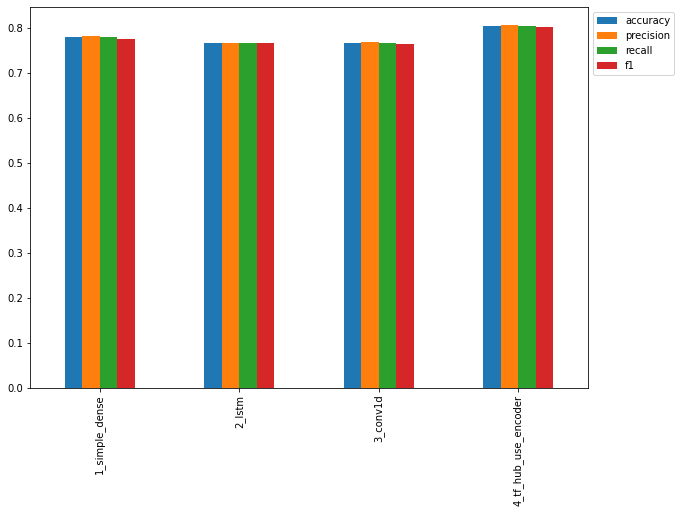

In [68]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

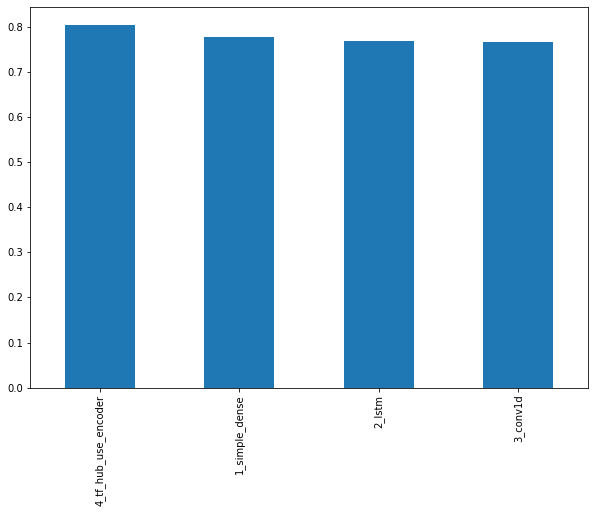

In [69]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Use the best trained model (model_4)to make predictions on the test dataset.

and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like).

Once you've done this, make a submission to the Kaggle competition.

In [70]:
# Make predictions with the model
pred_probs = model_4.predict(test_df['text'].to_numpy())

# Convert prediction probs to labels
preds = tf.squeeze(tf.round(pred_probs))
preds = tf.cast(preds, dtype=tf.int32)

102/102 [==============================] - 2s 22ms/step


In [71]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [72]:
submission = pd.DataFrame({"id": test_df['id'].values,
                           'target': (preds.numpy())})

In [73]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [74]:
preds[:20]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
      dtype=int32)>

In [75]:
submission.to_csv('submission.csv' , index = False)

## Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?

* model_3 -> Conv1D Model
* model_2 --> LSTM Model
* model_4 --> TFHub Model

Now let's get the predictions for each model and perform majority model

In [76]:
test_sentences = test_df['text'].to_numpy()

# Checking the shapes 
test_sentences.shape

(3263,)

In [77]:
# Getting the model predictions 

def give_preds(model, test_sentences):
  '''
  This model takes a model and the test sentences as input. 
  Returns the prediction array of [0,1.....]
  '''
  pred_probs = model.predict(test_sentences)
  preds = tf.squeeze(tf.round(pred_probs))
  preds = tf.cast(preds , dtype = tf.int32)

  return preds

In [78]:
# Getting the predictions for our 3 models 
model_4_preds = give_preds(model_1 , test_sentences)
model_2_preds = give_preds(model_2 ,test_sentences)
model_3_preds = give_preds(model_3 , test_sentences)

# Checking the shapes of our prediction 
model_4_preds.shape , model_2_preds.shape , model_3_preds.shape

102/102 [==============================] - 0s 4ms/step


(TensorShape([3263]), TensorShape([3263]), TensorShape([3263]))

In [80]:
model_4_preds[:5] , model_2_preds[:5] , model_3_preds[:5]

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 0, 1, 1, 1], dtype=int32)>)

In [81]:
# Creating a dataframe of our predictions 

preds_df = pd.DataFrame({'USE_model': model_4_preds , 
              'LSTM_model': model_2_preds , 
              'Conv1D_model': model_3_preds})
preds_df.head()

,USE_model,LSTM_model,Conv1D_model
0,0,0,1
1,0,0,0
2,1,1,1
3,0,0,1
4,1,1,1


In [82]:
# Majority voted predictions of our model
preds_df['majority_vote_preds'] = preds_df.mode(axis = 1)
preds_df.head()

,USE_model,LSTM_model,Conv1D_model,majority_vote_preds
0,0,0,1,0
1,0,0,0,0
2,1,1,1,1
3,0,0,1,0
4,1,1,1,1


In [83]:
# Converting the column into a numpy array 
mode_preds_array = preds_df['majority_vote_preds'].to_numpy()
mode_preds_array

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

## Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

Our best performing model is the model from the tensorflow hub.

In [84]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [85]:
# Predictions on the validation sentences 
val_preds = give_preds(model_4 , val_sentences)

# Creating a array of our class names 
class_names = ['not_a_disaster' , 'disaster']

# Checking the preds and true labels shape
val_preds.shape , val_labels.shape

24/24 [==============================] - 1s 25ms/step


(TensorShape([762]), (762,))

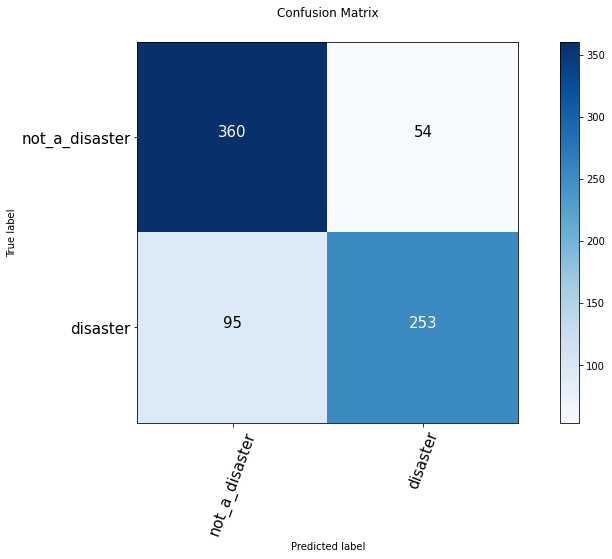

In [86]:
# Plotting the confusion matrix 
make_confusion_matrix(y_true= val_labels , 
                      y_pred = val_preds , 
                      classes = class_names , 
                      figsize= (15 , 7), 
                      norm = False , 
                      savefig = True , 
                      text_size = 15)